processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3
processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


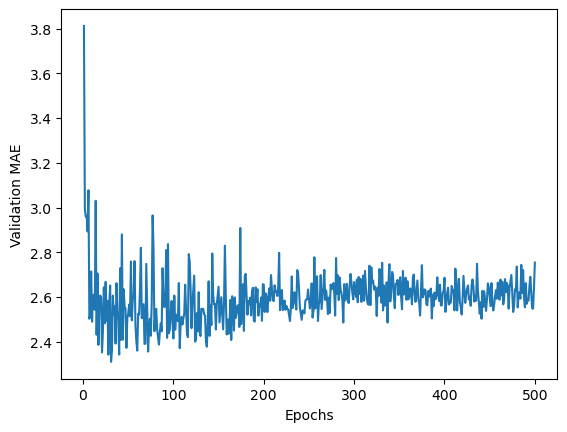

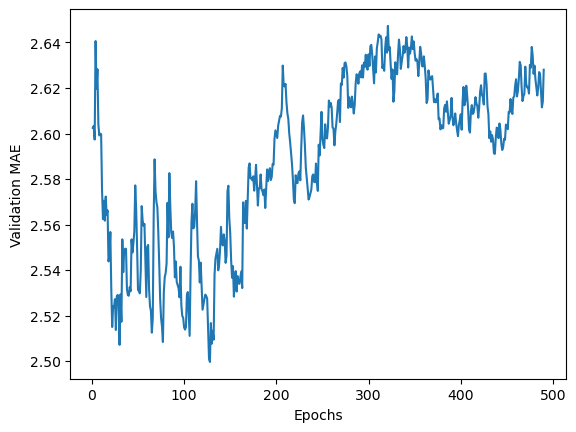

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.1460 - mae: 1.0777  
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 11.0319 - mae: 2.2511
train mae: 1.1606463193893433
test mae: 2.4314866065979004


In [7]:
import keras
keras.__version__

from keras.datasets import boston_housing
(train_data, train_targets), (test_data, test_targets) =  boston_housing.load_data()

train_data.shape
test_data.shape
train_targets

mean = train_data.mean(axis=0)
train_data -= mean
std = train_data.std(axis=0)
train_data /= std

test_data -= mean
test_data /= std

from keras import models
from keras import layers

def build_model():
    # Because we will need to instantiate
    # the same model multiple times,
    # we use a function to construct it.
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu',input_shape=(train_data.shape[1],))) #第一層，64個神經元，activation函數為relu/sigmoid/softplus
    model.add(layers.Dense(128, activation='relu')) #第二層，64個神經元，activation函數為relu/sigmoid/softplus
    model.add(layers.Dense(128, activation='relu')) #第三層，64個神經元，activation函數為relu/sigmoid/softplus
    model.add(layers.Dense(1)) #最後一層，輸出值(房價預測)
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return model

import numpy as np

k = 4
num_val_samples = len(train_data) // k
num_epochs = 100
all_scores = []
for i in range(k):
    print('processing fold #', i)
    # Prepare the validation data: data from partition # k
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]

    # Prepare the training data: data from all other partitions
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],
        axis=0)

    # Build the Keras model (already compiled)
    model = build_model()
    # Train the model (in silent mode, verbose=0)
    model.fit(partial_train_data, partial_train_targets,
              epochs=num_epochs, batch_size=1, verbose=0)
    # Evaluate the model on the validation data
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
    all_scores.append(val_mae)

all_scores
np.mean(all_scores)

from keras import backend as K
# Some memory clean-up
K.clear_session()

num_epochs = 500
all_mae_histories = []
for i in range(k):
    print('processing fold #', i)
    # Prepare the validation data: data from partition # k
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]

    # Prepare the training data: data from all other partitions
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],
        axis=0)

    # Build the Keras model (already compiled)
    model = build_model()
    # Train the model (in silent mode, verbose=0)
    history = model.fit(partial_train_data, partial_train_targets,
                        validation_data=(val_data, val_targets),
                        epochs=num_epochs, batch_size=1, verbose=0)
    mae_history = history.history['val_mae']
    all_mae_histories.append(mae_history)

average_mae_history = [
    np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

import matplotlib.pyplot as plt

plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

def smooth_curve(points, factor=0.9):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

smooth_mae_history = smooth_curve(average_mae_history[10:])

plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

# Get a fresh, compiled model. 使用完整的數據集重新訓練模型
model = build_model()
# Train it on the entirety of the data. 在測試集上評估模型
model.fit(train_data, train_targets,
          epochs=120, batch_size=32, verbose=0)
train_mse_score, train_mae_score = model.evaluate(train_data, train_targets)
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)
print('train mae:', train_mae_score)
print('test mae:', test_mae_score)